In [42]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [43]:
#clones_file = "cdr3-clones-AB-ADA-IGH_HUMAN-after-reassignment.csv" # 3MB file (run28)
#pt_file = "20180514_Run028_pt-table_CORRECT.csv"
#plotfile = "run28-AB-ADA-IGH_HUMAN.pdf"

#clones_file = "cdr3-clones-Eomes-TRB_MOUSE-after-reassignment.csv"  # 14 MB (run28)
#pt_file = "20180514_Run028_pt-table_CORRECT.csv"
#plotfile = "run28-Eomes-TRB_MOUSE.pdf"

#clones_file = "cdr3-clones-Prairi-IGH_HUMAN-after-reassignment.csv" # 22 MB (run25)
#pt_file = "20180326_RUN25_pt.table.csv"
#plotfile = "run25-Prairi-IGH_HUMAN.pdf"

#clones_file = "cdr3-clones-AB-RBF-TRB_HUMAN-after-reassignment.csv" # 300 MB file (run25)
#pt_file = "20180326_RUN25_pt.table.csv"
#plotfile = "run25-AB-RBF-TRB_HUMAN.pdf"

clones_file = "cdr3-clones-CEA-RTX-TRB_HUMAN-after-reassignment.csv"
pt_file = "20180517_RUN26_pt.table_CORRECTED.csv"
plotfile = "run26-CEA-Ada-TRB_HUMAN.pdf"

## Import clonesdata

In [44]:
clones = pd.read_csv(clones_file, sep="\t")

In [45]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,read_perc,umi_perc
0,RTX-CEA01-Tu_S85,ACGTACGT,CASSPQREGRDNEQFFG,25230,15954,TRBV18,"TRBJ2-1,TRBJ2-7",57.661981,50.808917
1,RTX-CEA01-Tu_S85,ACGTACGT,CASSLAGVSQYFG,2254,1836,TRBV11-2,TRBJ2-3,5.151411,5.847134
2,RTX-CEA01-Tu_S85,ACGTACGT,CSVGQGTGNTIYFG,1161,745,TRBV29-1,TRBJ1-3,2.653411,2.372611
3,RTX-CEA01-Tu_S85,ACGTACGT,CASSSSRVGGLYNEQFFG,936,735,TRBV11-1,"TRBJ2-1,TRBJ2-7",2.139184,2.340764
4,RTX-CEA01-Tu_S85,ACGTACGT,CASSLGVGQGSHGYTFG,583,518,TRBV7-8,TRBJ1-2,1.332419,1.649682


## Import patient table

In [46]:
pt = pd.read_csv(pt_file, sep=";")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})

In [47]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [48]:
pt.head()

,Sample,Patient
0,AB-RBF002-Bu_S1,17-02-0005
1,AB-RBF003-Bu_S2,17-02-0005
2,AB-RBF007-Bu_S3,17-02-0005
3,AB-RBF009-Bu_S4,1050495
4,AB-RBF012-Bu_S5,28-01-0027


## Merge clones with pt

In [49]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df = df.set_index(['Patient', 'Sample'])
df.head()

MID             cdr3pep   freq  uniq_umis  \
Patient    Sample                                                             
08-01-0008 RTX-CEA01-Tu_S85  ACGTACGT   CASSPQREGRDNEQFFG  25230      15954   
           RTX-CEA01-Tu_S85  ACGTACGT       CASSLAGVSQYFG   2254       1836   
           RTX-CEA01-Tu_S85  ACGTACGT      CSVGQGTGNTIYFG   1161        745   
           RTX-CEA01-Tu_S85  ACGTACGT  CASSSSRVGGLYNEQFFG    936        735   
           RTX-CEA01-Tu_S85  ACGTACGT   CASSLGVGQGSHGYTFG    583        518   

                                V_sub            J_sub  read_perc   umi_perc  
Patient    Sample                                                             
08-01-0008 RTX-CEA01-Tu_S85    TRBV18  TRBJ2-1,TRBJ2-7  57.661981  50.808917  
           RTX-CEA01-Tu_S85  TRBV11-2          TRBJ2-3   5.151411   5.847134  
           RTX-CEA01-Tu_S85  TRBV29-1          TRBJ1-3   2.653411   2.372611  
           RTX-CEA01-Tu_S85  TRBV11-1  TRBJ2-1,TRBJ2-7   2.139184   2.340764  
           RTX-CEA01-Tu_S85   TRBV7-8          TRBJ1-2   1.332419   1.649682

## Count overlapping clones between samples

In [50]:
# Sort index for better performance
df = df.sort_index()

# Make empty data frame for the distance matrix
colnames = list(set(df.index))
colnames
colnames.sort()
overlap = pd.DataFrame(index=colnames, columns=colnames, dtype=np.float)

In [51]:
# Function to count overlapping elements (cdr3pep): Jaccard index
jaccard = lambda x, y: len(set(x).intersection(set(y))) / len(set(x).union(set(y)))

In [52]:
# Function to count overlapping elements (cdr3pep): Sorensen index
sorensen = lambda x, y: 2 * len(set(x).intersection(set(y))) / (len(set(x)) + len(set(y)))

In [53]:
# Function to count overlapping elements, taking abundance into account: Bray-Curtis (Sorensen generalized)
def bray_curtis(x,y):
    '''
    From: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.1334&rep=rep1&type=pdf
    In: x (dataframe), y (dataframe)
    Out: similarity (number)
    '''
    merged = pd.merge(x, y, how='outer', on = 'cdr3pep')
    merged = merged.fillna(0)   # Replace NaN with 0
    merged['minimum'] = [i for i in map(min, merged['freq_x'], merged['freq_y'])]
    similarity = 2 * sum(merged['minimum']) / (sum(merged['freq_x']) + sum(merged['freq_y']))
    return(similarity)

In [54]:
# Function to count overlapping elements, taking abundance into account: Bray-Curtis
def jaccard_generalized(x,y):
    '''
    From: https://en.wikipedia.org/wiki/Jaccard_index
    In: x (dataframe), y (dataframe)
    Out: similarity (number)
    '''
    #x = df.loc[('M5', 'Eomes-01_S9')][['cdr3pep', 'read_perc']]
    #y = df.loc[('M5', 'Eomes-02_S10')][['cdr3pep', 'read_perc']]
    merged = pd.merge(x, y, how='outer', on = 'cdr3pep')
    merged = merged.fillna(0)   # Replace NaN with 0
    merged['minimum'] = [i for i in map(min, merged['freq_x'], merged['freq_y'])]
    merged['maximum'] = [i for i in map(max, merged['freq_x'], merged['freq_y'])]
    similarity = sum(merged['minimum']) / sum(merged['maximum'])
    return(similarity)

In [55]:
# Calculate distance between all samples
for x in overlap.index:
    for y in overlap.index:
        #overlap[x][y] = max(sorensen(df.loc[x]['cdr3pep'], df.loc[y]['cdr3pep']), 0.0000000001)
        overlap[x][y] = max(bray_curtis(df.loc[x][['cdr3pep', 'freq']], df.loc[y][['cdr3pep', 'freq']]), 0.0000000001)

In [56]:
overlap.head()

,"(08-01-0008, RTX-CEA01-Tu_S85)","(08-01-0008, RTX-CEA02-Tu_S86)","(08-01-0008, RTX-CEA03-Tu_S87)","(08-01-0008, RTX-CEA04-Tu_S88)","(08-01-0008, RTX-CEA05-Tu_S89)","(08-01-0008, RTX-CEA06-Tu_S90)","(09-01-0013, RTX-CEA58-Tu_S210)","(09-01-0013, RTX-CEA59-Tu_S211)","(10-01-0001, RTX-CEA14-Tu_S114)","(10-01-0001, RTX-CEA17-Tu_S132)",...,"(40-02-0005, RTX-CEA65-Tu_S215)","(40-02-0005, RTX-CEA66-Tu_S216)","(40-02-0005, RTX-CEA67-Tu_S217)","(40-02-0005, RTX-CEA68-Tu_S226)","(40-02-0005, RTX-CEA69-Tu_S227)","(40-02-0005, RTX-CEA72-Tu_S228)","(40-17-0010, RTX-CEA61-Tu_S212)","(40-17-0010, RTX-CEA63-Tu_S213)","(40-17-0010, RTX-CEA92-Tu_S246)","(40-17-0010, RTX-CEA94-Tu_S247)"
"(08-01-0008, RTX-CEA01-Tu_S85)",1.000000,0.758963,0.801948,0.742828,0.754364,0.674221,0.000148,0.000158,0.000823,0.000419,...,0.000536,0.000233,0.000543,0.000364,0.000215,0.000188,0.000147,0.000865,0.000134,0.000148
"(08-01-0008, RTX-CEA02-Tu_S86)",0.758963,1.000000,0.713642,0.699601,0.713101,0.662048,0.000435,0.000183,0.001020,0.000647,...,0.000510,0.000316,0.000282,0.000265,0.000302,0.000371,0.000182,0.000713,0.000326,0.000203
"(08-01-0008, RTX-CEA03-Tu_S87)",0.801948,0.713642,1.000000,0.775347,0.762793,0.711056,0.000290,0.000168,0.001562,0.001095,...,0.000741,0.000385,0.000521,0.000418,0.000429,0.000575,0.000201,0.000959,0.000715,0.000382
"(08-01-0008, RTX-CEA04-Tu_S88)",0.742828,0.699601,0.775347,1.000000,0.809473,0.772265,0.000042,0.000079,0.000679,0.000296,...,0.000483,0.000156,0.000299,0.000224,0.000135,0.000113,0.000111,0.000627,0.000081,0.000178
"(08-01-0008, RTX-CEA05-Tu_S89)",0.754364,0.713101,0.762793,0.809473,1.000000,0.727532,0.000240,0.000245,0.000703,0.000507,...,0.000623,0.000314,0.000353,0.000285,0.000225,0.000204,0.000167,0.000798,0.000175,0.000466


In [57]:
# Replace NaN and zero's with low number
overlap[overlap.isna()] = 0.0000000001
overlap[overlap == 0] = 0.0000000001

## Create a heatmap

In [58]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [59]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

Wrote run26-CEA-Ada-TRB_HUMAN.pdf to disk


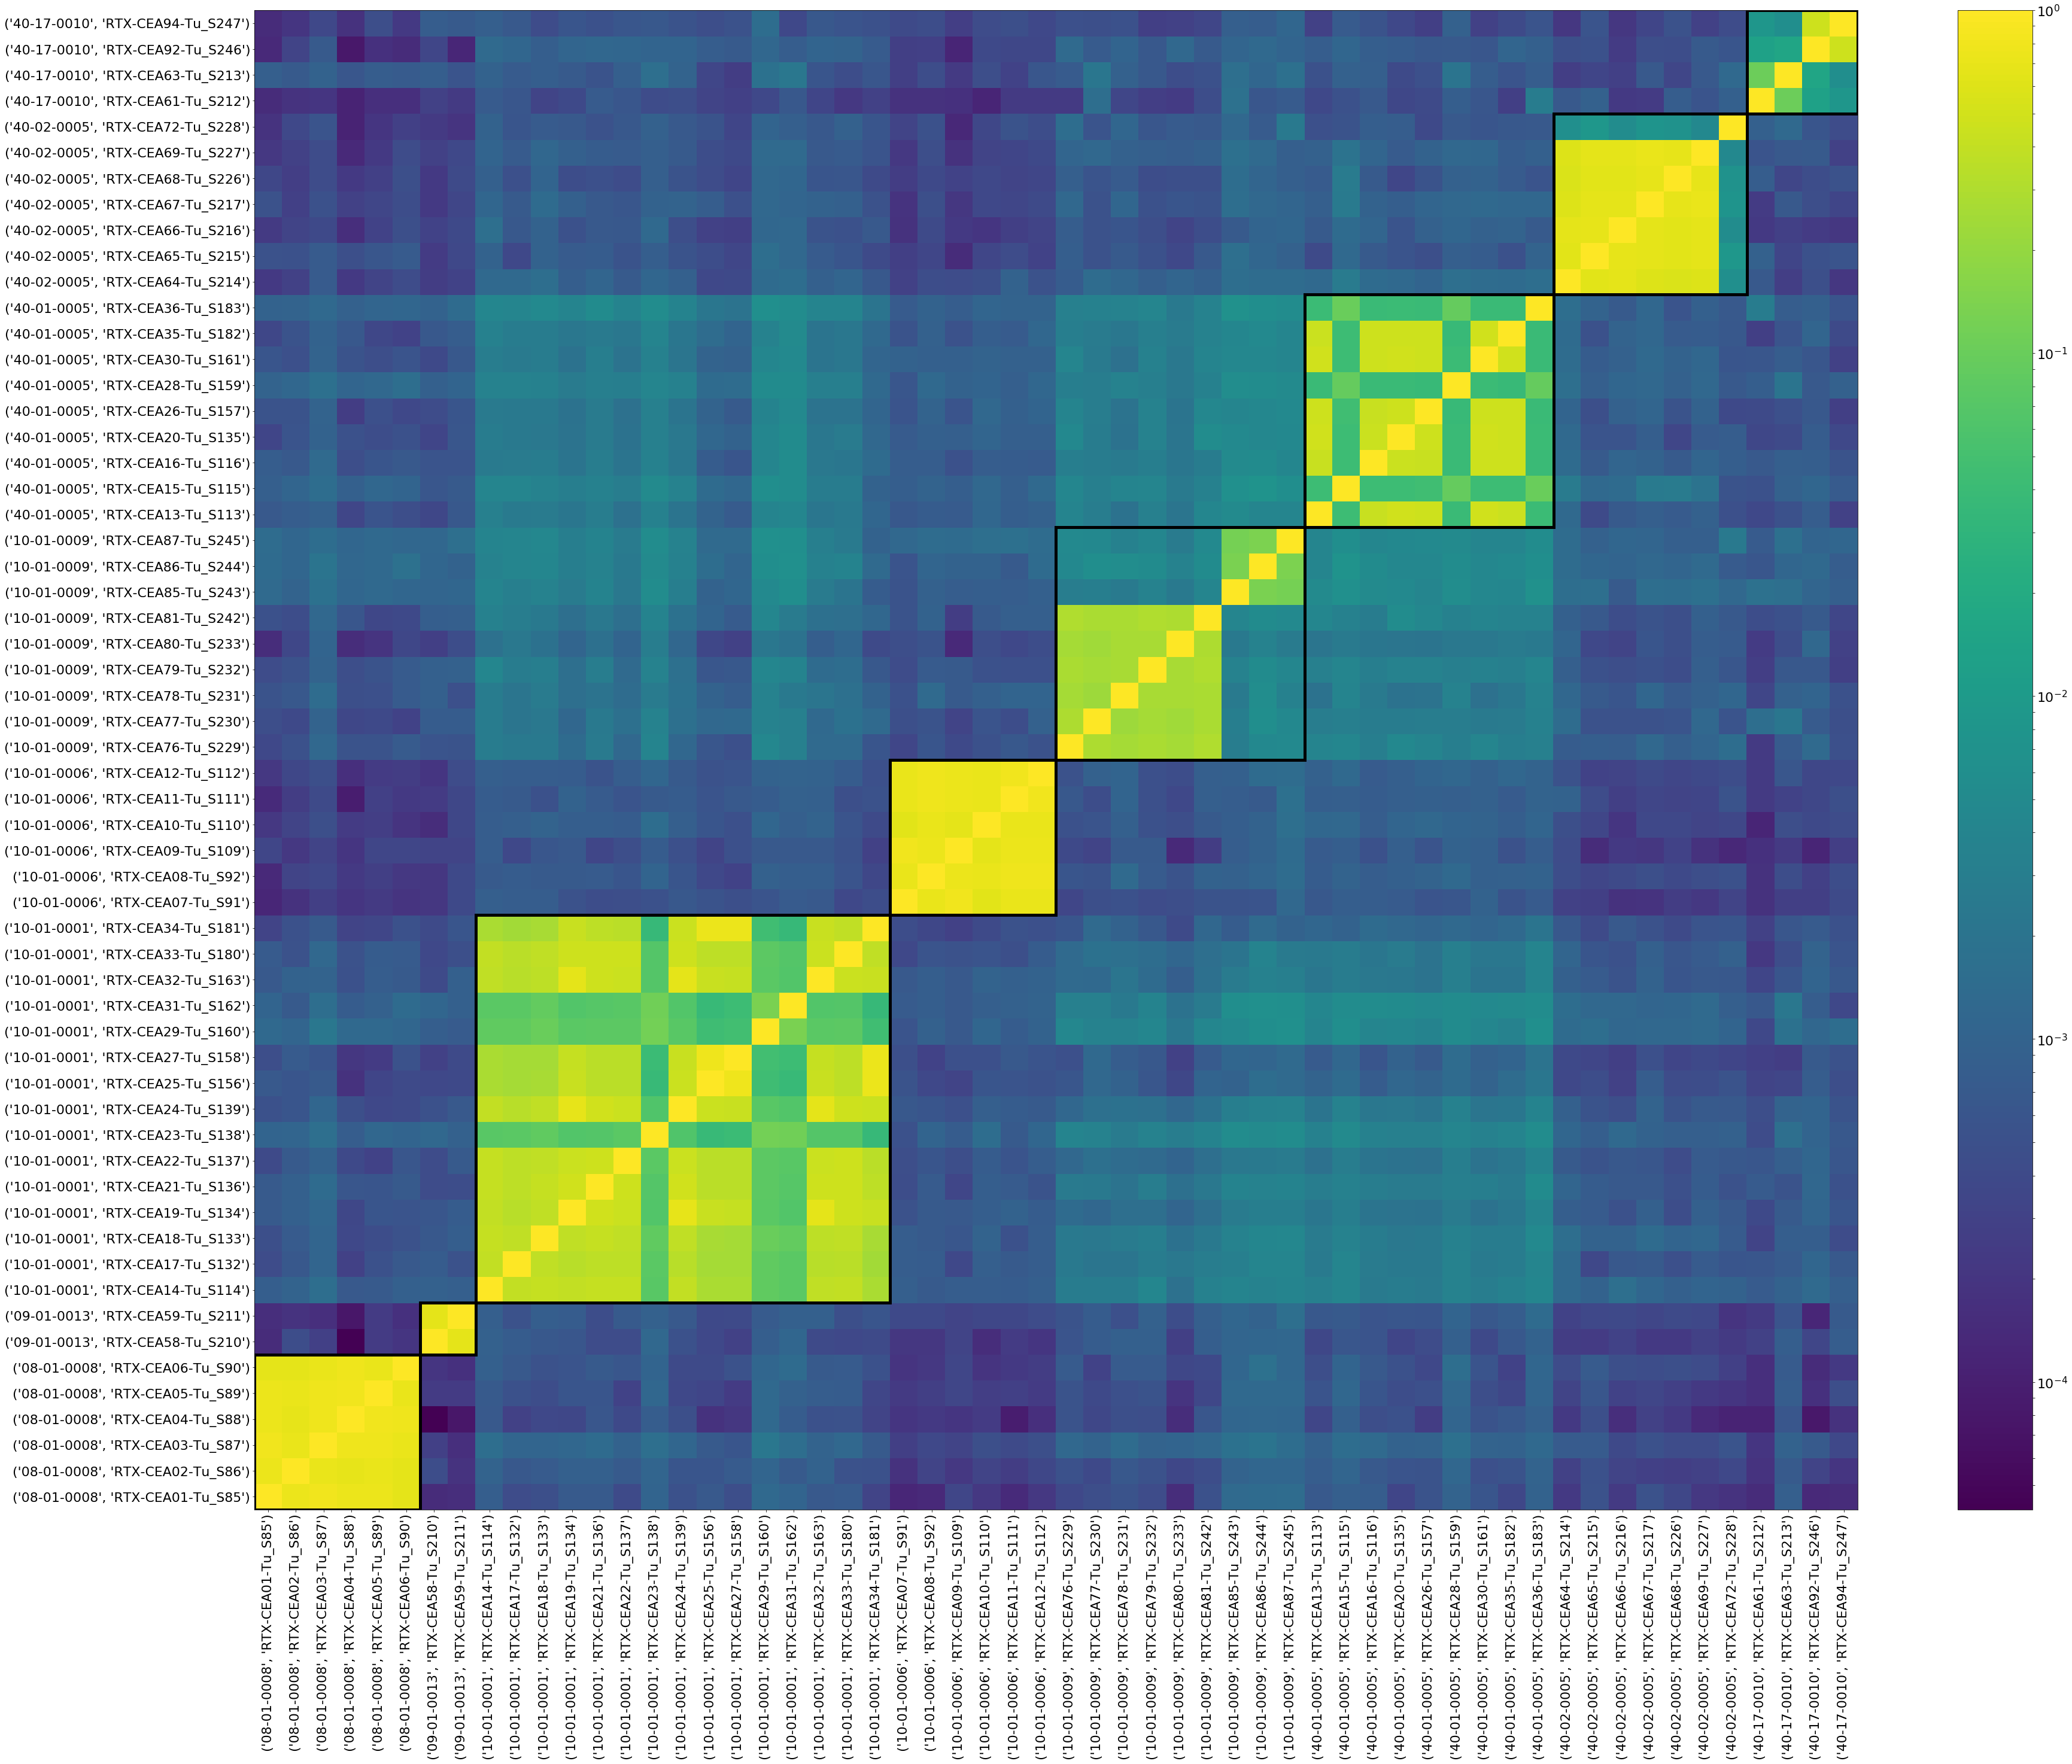

In [60]:
drawHeatmap(overlap)